In [222]:
# !pip install -q ddsketch cvxpy medmnist

In [1]:
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import cvxpy
import ddsketch
import medmnist
import pandas as pd
import torch
import numpy as np
from ddsketch import DDSketch

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

In [2]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

In [3]:
# path_to_experiments = Path('../experiments/')
# path_to_experiments = Path('experiments/')
path_to_experiments = Path('new_experiments/')

In [4]:
# dataset = 'mnist'
# dataset = 'svhn'
# dataset = 'fashion'
# dataset = 'cifar10'
dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'dermamnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
# dataset = 'fitzpatrick'

experiment_names = ['tct', 'fedavg', 'central', 'tct_iid', 'fedavg_iid']

fst, snd = map(itemgetter, range(2))

if dataset == 'fitzpatrick':
    # model = 'resnet18'
    model = 'efficientnet-b1'
    partition = 'skin_type_partition'
    # partition = 'three_label_partition'
    _val_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'val_df.csv')
    _test_df = pd.read_csv(path_to_experiments / f'fitzpatrick_tct_{model}_pretrained_{partition}' / 'test_df.csv')
    df = pd.concat([_val_df, _test_df]).reset_index()
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}_pretrained_{partition}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        # 'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}_pretrained_{partition}'), dataset=dataset),
        # 'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_pretrained_{partition}'), dataset=dataset),
        # 'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_pretrained_{partition}'), dataset=dataset),
        # 'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
        # 'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition_pretrained_{partition}'), dataset=dataset),
    }
    num_classes = 114
    clients_class_map = None
else:
    clients_class_map = helpers.get_client_map(dataset)
    num_classes = sum(map(len, clients_class_map.values()))
    model = 'small_resnet14'
    experiments = {
        'central': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}'), dataset=dataset),
        'tct': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}'), dataset=dataset),
        'fedavg': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}'), dataset=dataset),
        'fedprox': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedprox_{model}'), dataset=dataset),
        'tct_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}_iid_partition'), dataset=dataset),
        'fedavg_iid': helpers.load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}_iid_partition'), dataset=dataset),
    }
    
experiments = dict(filter(snd, experiments.items()))

In [5]:
for k, v in experiments.items():
    val_logits = v['val_scores']
    test_logits = v['test_scores']
    val_targets = v['val_targets']
    test_targets = v['test_targets']
    temp = ts.temp_scale(val_logits, val_targets, plot=False)
    val_scores = torch.softmax(val_logits / temp, 1)
    test_scores = torch.softmax(test_logits / temp, 1)
    experiments[k]['temp_val_scores'] = val_scores
    experiments[k]['temp_test_scores'] = test_scores

In [6]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

for k, v in experiments.items():
    print(f"\n{k.upper().center(20, '=')}")
    print(f" val accuracy {accuracy(v['val_scores'], v['val_targets']):.0%}")
    print(f"test accuracy {accuracy(v['test_scores'], v['test_targets']):.0%}")



======CENTRAL=======
 val accuracy 63%
test accuracy 61%

========TCT=========
 val accuracy 59%
test accuracy 58%

=======FEDAVG=======
 val accuracy 34%
test accuracy 32%

======FEDPROX=======
 val accuracy 31%
test accuracy 31%

======TCT_IID=======
 val accuracy 62%
test accuracy 62%

=====FEDAVG_IID=====
 val accuracy 61%
test accuracy 60%


In [10]:
reload(cp)
tct = experiments['tct']
avg = experiments['fedavg']
prox = experiments['fedprox']

tct_val_scores = tct['temp_val_scores']
tct_test_scores =tct['temp_test_scores']
tct_val_targets = tct['val_targets']
tct_test_targets = tct['test_targets']
avg_val_scores = avg['temp_val_scores']
avg_test_scores = avg['temp_test_scores']
avg_val_targets = avg['val_targets']
avg_test_targets = avg['test_targets']
prox_val_scores = prox['temp_val_scores']
prox_test_scores = prox['temp_test_scores']
prox_val_targets = prox['val_targets']
prox_test_targets = prox['test_targets']

assert (avg_val_targets == tct_val_targets).all()
assert (avg_test_targets == tct_test_targets).all()
assert (prox_val_targets == tct_val_targets).all()
assert (prox_test_targets == tct_test_targets).all()

tct_corr = tct_test_scores.argmax(1) == tct_test_targets
tct_incorr = ~tct_corr
prox_corr = prox_test_scores.argmax(1) == prox_test_targets
prox_incorr = ~prox_corr
both_corr = tct_corr & prox_corr
both_incorr = tct_incorr & prox_incorr
avg_corr = avg_test_scores.argmax(1) == avg_test_targets
all_corr = both_corr & avg_corr

In [22]:
alpha = 0.1
lam_reg = 0.001
tct_q, tct_dist = cp.calibrate_lac(tct_val_scores, tct_val_targets, alpha=alpha, return_dist=True)
prox_q, prox_dist = cp.calibrate_lac(prox_val_scores, prox_val_targets, alpha=alpha, return_dist=True)
avg_q, avg_dist = cp.calibrate_lac(avg_val_scores, avg_val_targets, alpha=alpha, return_dist=True)
tct_psets = cp.inference_lac(tct_test_scores[all_corr], tct_q)
prox_psets = cp.inference_lac(prox_test_scores[all_corr], prox_q)
avg_psets = cp.inference_lac(avg_test_scores[all_corr], avg_q)
# tct_q, tct_dist = cp.calibrate_aps(tct_val_scores, tct_val_targets, alpha=alpha, return_dist=True)
# prox_q, prox_dist = cp.calibrate_aps(prox_val_scores, prox_val_targets, alpha=alpha, return_dist=True)
# avg_q, avg_dist = cp.calibrate_aps(avg_val_scores, avg_val_targets, alpha=alpha, return_dist=True)
# tct_psets = cp.inference_aps(tct_test_scores[all_corr], tct_q)
# prox_psets = cp.inference_aps(prox_test_scores[all_corr], prox_q)
# avg_psets = cp.inference_aps(avg_test_scores[all_corr], avg_q)
# tct_q, tct_dist = cp.calibrate_raps(tct_val_scores, tct_val_targets, alpha=alpha, return_dist=True, lam_reg=lam_reg)
# prox_q, prox_dist = cp.calibrate_raps(prox_val_scores, prox_val_targets, alpha=alpha, return_dist=True, lam_reg=lam_reg)
# avg_q, avg_dist = cp.calibrate_raps(avg_val_scores, avg_val_targets, alpha=alpha, return_dist=True, lam_reg=lam_reg)
# tct_psets = cp.inference_raps(tct_test_scores[all_corr], tct_q)
# prox_psets = cp.inference_raps(prox_test_scores[all_corr], prox_q)
# avg_psets = cp.inference_raps(avg_test_scores[all_corr], avg_q)
print(tct_q, prox_q)

tct_size_counts = tct_psets.sum(1).bincount().tolist()
prox_size_counts = prox_psets.sum(1).bincount().tolist()
avg_size_counts = avg_psets.sum(1).bincount().tolist()

print(cp.get_coverage(tct_psets, tct_test_targets[all_corr]))
print(cp.get_coverage(prox_psets, prox_test_targets[all_corr]))
print(cp.get_coverage(avg_psets, avg_test_targets[all_corr]))
print()
print(cp.get_size(tct_psets))
print(cp.get_size(prox_psets))
print(cp.get_size(avg_psets))
print()
print((tct_test_scores[all_corr].argmax(1) == tct_test_targets[all_corr]).float().mean())
print((prox_test_scores[all_corr].argmax(1) == prox_test_targets[all_corr]).float().mean())
print((avg_test_scores[all_corr].argmax(1) == avg_test_targets[all_corr]).float().mean())

tensor(0.9840) tensor(0.9919)
1.0
1.0
1.0

3.2
12.9
13.2

tensor(1.)
tensor(1.)
tensor(1.)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


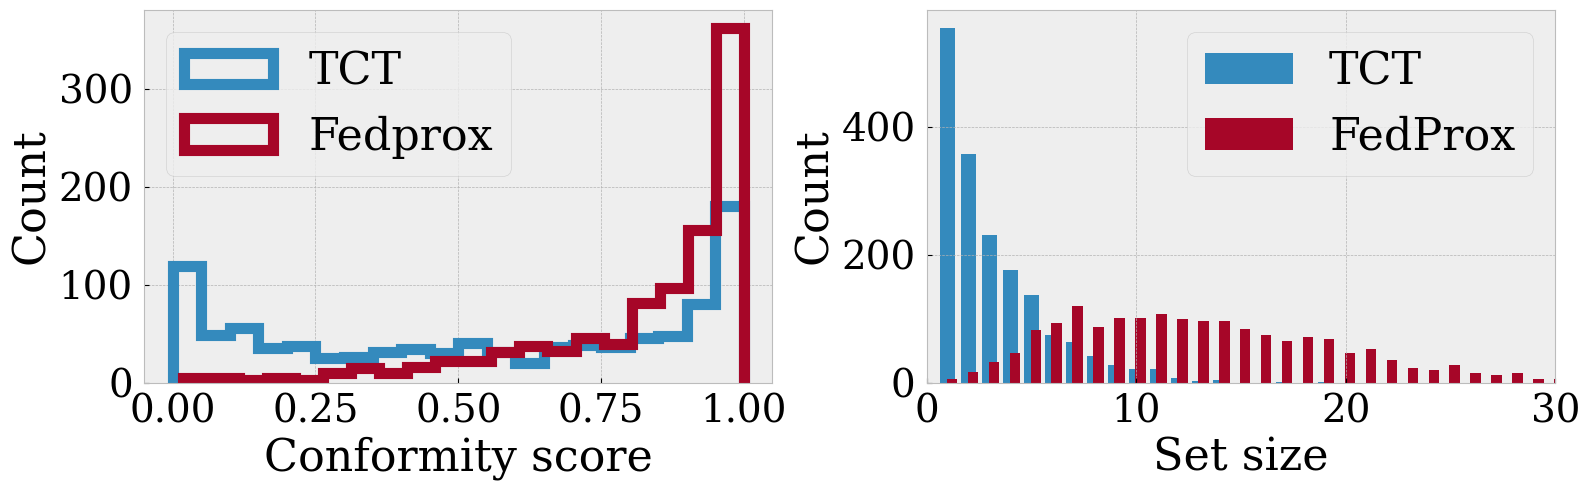

In [23]:
fontsize = 32
lw = 8
offset = 0.2
width = 0.5
bins = 20
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
ax[0].hist(tct_dist,  bins=bins, color='C0', label='TCT', histtype='step', lw=lw)
# ax[0].hist(prox_dist,  bins=bins, color='C1', label='Fedprox', histtype='stepfilled', lw=lw)
ax[0].hist(prox_dist,  bins=bins, color='C1', label='Fedprox', histtype='step', lw=lw)
ax[0].set_xlabel('Conformity score', fontsize=fontsize)
ax[0].set_ylabel('Count', fontsize=fontsize)
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[0].set_yticks([0, 500, 1000, 1500])
ax[0].legend(fontsize=fontsize, loc='upper left')
# ax[0].set_xlim(0, 1.05)
ax[1].bar(np.arange(len(tct_size_counts)), tct_size_counts, width=width+0.2, label='TCT')
# ax[1].step(np.arange(len(tct_size_counts)), tct_size_counts, label='TCT', lw=lw)
# ax[1].hist(tct_psets.sum(1), label='TCT', histtype='step', lw=lw, bins=bins)
ax[1].bar(np.arange(len(prox_size_counts)) + offset, prox_size_counts, width=width, label='FedProx', color='C1')
# ax[1].hist(prox_psets.sum(1), label='FedProx', color='C1', bins=bins)
ax[1].legend(fontsize=fontsize, loc='upper right')
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].set_xlabel('Set size', fontsize=fontsize)
ax[1].set_ylabel('Count', fontsize=fontsize)
# ax[1].set_yticks([0, 500, 1000])
ax[1].set_xlim(0, 30)
# ax[1].set_xticks([1, 15, 30, 45, 60])
# ax[1].set_xticks([1, 10, 20, 30])
plt.tight_layout()
plt.savefig(fig_dir / f'experiment-5-{dataset}-nonconformity.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


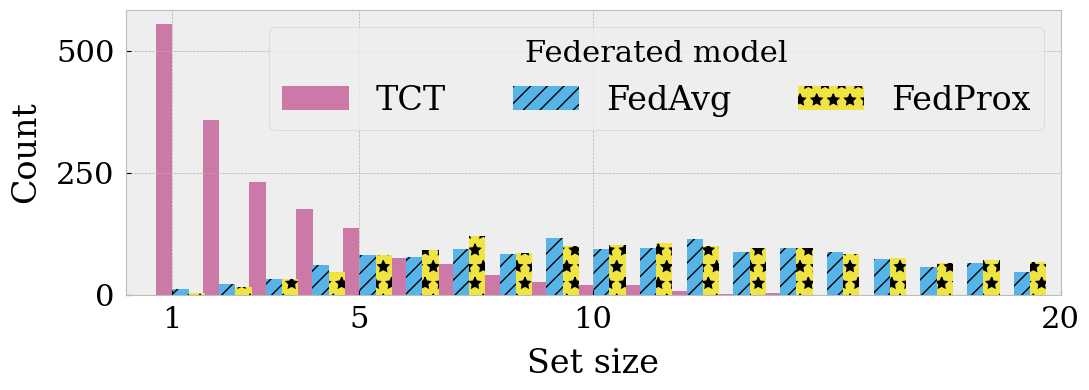

In [241]:

fontsize = 24
lw = 8
offset = 0.35
width = -0.35
bins = 20
fig, ax = plt.subplots(ncols=1, figsize=(11, 4))
ax.bar(np.arange(len(tct_size_counts)), tct_size_counts, width=width, label='TCT', color='C5', align='edge')
ax.bar(np.arange(len(avg_size_counts)) + offset, avg_size_counts, width=width, label='FedAvg', color='C6', hatch='//', align='edge')
ax.bar(np.arange(len(prox_size_counts)) + 2*offset, prox_size_counts, width=width, label='FedProx', color='C8', hatch='*', align='edge')
ax.legend(fontsize=fontsize, loc='upper right', title='Federated model', title_fontsize=fontsize-2, ncol=3)
ax.xaxis.set_tick_params(labelsize=fontsize-2, pad=8)
ax.yaxis.set_tick_params(labelsize=fontsize-2, pad=8)
ax.set_xlabel('Set size', fontsize=fontsize, labelpad=10)
ax.set_ylabel('Count', fontsize=fontsize, labelpad=10)
# ax.set_xlim(0, 35)
ax.set_xlim(0, 20)
ax.set_yticks([0, 250, 500])
ax.set_xticks([1, 5, 10, 20])
# ax[1].set_xticks([1, 10, 20, 30])
plt.tight_layout()
plt.savefig(fig_dir / f'experiment-5-{dataset}-nonconformity.eps', bbox_inches='tight')
plt.show()

In [14]:
alpha = 0.05
k = 4
allow_empty_sets = True
cal_index = val_df.aggregated_fitzpatrick_scale == k
test_index = test_df.aggregated_fitzpatrick_scale == 6
val_scores = experiments['fedavg']['temp_val_scores']
test_scores = experiments['fedavg']['temp_test_scores']
val_targets = experiments['fedavg']['val_targets']
test_targets = experiments['fedavg']['test_targets']
q = cp.calibrate_lac(val_scores[cal_index], val_targets[cal_index], alpha=alpha, )
q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha, )
cal_psets = cp.inference_lac(test_scores[test_df.aggregated_fitzpatrick_scale == k], q, allow_empty_sets=allow_empty_sets)
test_psets = cp.inference_lac(test_scores[test_index], q, allow_empty_sets=allow_empty_sets)

cal_coverage = cp.get_coverage(cal_psets, test_targets[test_df.aggregated_fitzpatrick_scale == k])
cal_size = cp.get_size(cal_psets)
test_coverage = cp.get_coverage(test_psets, test_targets[test_index])
test_size = cp.get_size(test_psets)

print(f'skin type 3\t {cal_coverage:.2f}  |  {cal_size:.1f}')
print(f'skin type 6\t {test_coverage:.2f}  |  {test_size:.1f}')

NameError: name 'val_df' is not defined

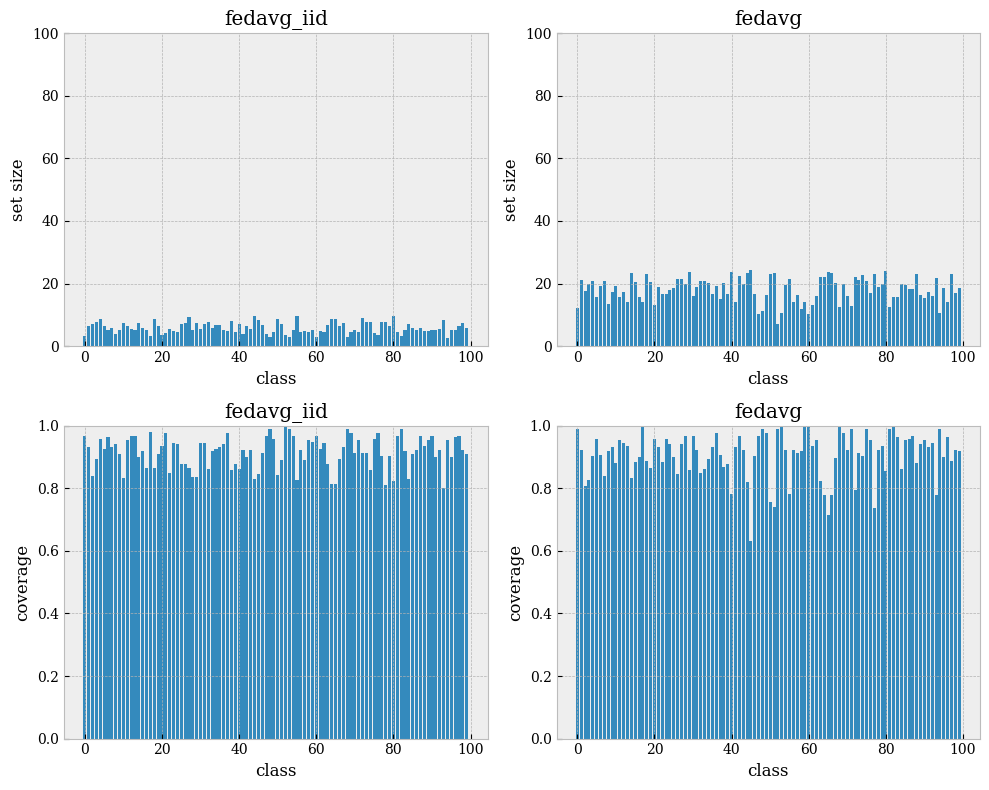

In [376]:
exps = ['central', 'fedavg_iid', 'fedavg']
exps = ['fedavg_iid', 'fedavg']

fig, ax = plt.subplots(ncols=len(exps), nrows=2, figsize=(10, 8))
for i, exp in enumerate(exps):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=0.1)
    psets = cp.inference_lac(test_scores, q)

    ax[0, i].set_title(exp)
    ax[0, i].bar(range(num_classes), cp.get_efficiency_by_class(psets, test_targets, num_classes=num_classes).values())
    ax[0, i].set_xlabel('class')
    ax[0, i].set_ylabel('set size')
    ax[0, i].set_ylim(0, num_classes)
    # ax[i].set_ylim(0, 20)
    # plt.bar(range(num_classes), test_scores.std(0))
    
    ax[1, i].set_title(exp)
    ax[1, i].bar(range(num_classes), cp.get_coverage_by_class(psets, test_targets, num_classes=num_classes).values())
    ax[1, i].set_xlabel('class')
    ax[1, i].set_ylabel('coverage')
    ax[1, i].set_ylim(0., 1)
plt.tight_layout()
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


fedavg_iid 0.9636666774749756
fedavg_iid 10.9
fedavg 0.9483333230018616
fedavg 26.0


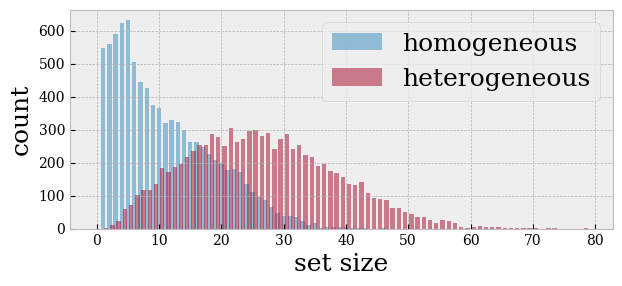

In [377]:
alpha = 0.05
# alpha = 0.15
fontsize = 18
allow_empty_sets = False 

fig, ax = plt.subplots(ncols=1, figsize=(7, 3))
# fig.suptitle(exp + ' lac', fontsize=fontsize+4, y=1.10)

for i, exp in enumerate(('fedavg_iid', 'fedavg')):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
    psets = cp.inference_lac(test_scores, q, allow_empty_sets=allow_empty_sets)
    size_counts = psets.sum(1).bincount().tolist()
    print(exp, cp.get_coverage(psets, test_targets))
    print(exp, cp.get_size(psets))
    if exp == 'fedavg_iid':
        label = 'homogeneous'
        offset = 0
    elif exp == 'fedavg':
        label = 'heterogeneous'
        offset = 0.5
    ax.bar(np.arange(len(size_counts)) + offset, size_counts, width=0.7, label=label, alpha=0.5)
    # ax[i].set_title(fr'$\alpha$={alpha}', fontsize=fontsize, y=1.05)
    ax.set_xlabel('set size', fontsize=fontsize)
    ax.set_ylabel('count', fontsize=fontsize)
    # ax.set_xlim(0, 50)
        
    # fig.tight_layout()
plt.legend(fontsize=fontsize, fancybox=True)
plt.subplots_adjust(bottom=0.15)
plt.savefig('/Users/clu/Desktop/heterogeneous-set-sizes.eps')
plt.show()


correct fedavg_iid 1.0
correct fedavg_iid 4.3
incorrect fedavg_iid 0.7961971163749695
incorrect fedavg_iid 8.2
correct fedavg 1.0
correct fedavg 14.7
incorrect fedavg 0.8621426224708557
incorrect fedavg 19.8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


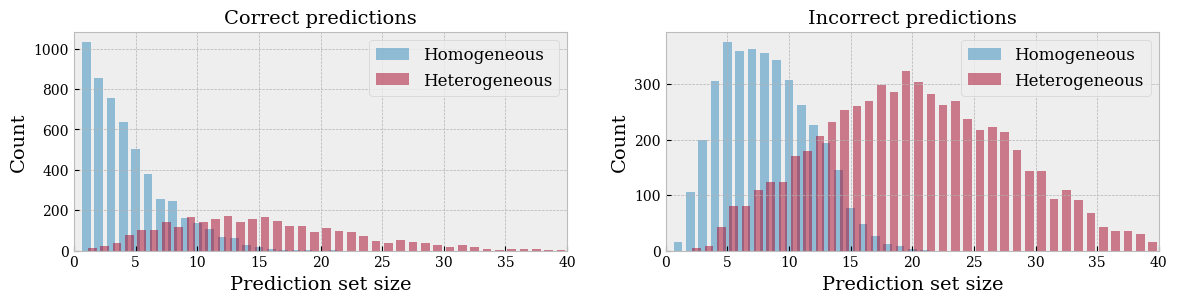

In [378]:
# alpha = 0.05
alpha = 0.10
y = 1
# alpha = 0.1
fontsize = 14
allow_empty_sets = False 

fig, ax = plt.subplots(ncols=2, figsize=(14, 3))
# fig.suptitle(exp + ' lac', fontsize=fontsize+4, y=1.10)

for i, exp in enumerate(('fedavg_iid', 'fedavg')):
    val_scores = experiments[exp]['temp_val_scores']
    test_scores = experiments[exp]['temp_test_scores']
    val_targets = experiments[exp]['val_targets']
    test_targets = experiments[exp]['test_targets']

    q = cp.calibrate_lac(val_scores, val_targets, alpha=alpha)
    psets = cp.inference_lac(test_scores, q, allow_empty_sets=allow_empty_sets)
    
    correct_index = test_scores.argmax(1) == test_targets
    correct_psets = psets[correct_index]
    correct_test_targets = test_targets[correct_index]
    
    correct_size_counts = correct_psets.sum(1).bincount().tolist()
    print('correct', exp, cp.get_coverage(correct_psets, correct_test_targets))
    print('correct', exp, cp.get_size(correct_psets))
    
    incorrect_index = test_scores.argmax(1) != test_targets
    incorrect_psets = psets[incorrect_index]
    incorrect_test_targets = test_targets[incorrect_index]
    
    incorrect_size_counts = incorrect_psets.sum(1).bincount().tolist()
    print('incorrect', exp, cp.get_coverage(incorrect_psets, incorrect_test_targets))
    print('incorrect', exp, cp.get_size(incorrect_psets))
    
    
    if exp == 'fedavg_iid':
        label = 'Homogeneous'
        offset = 0
    elif exp == 'fedavg':
        label = 'Heterogeneous'
        offset = 0.5
    
    ax[0].bar(np.arange(len(correct_size_counts)) + offset, correct_size_counts, width=0.7, label=label, alpha=0.5)
    ax[0].set_title(fr'Correct predictions', fontsize=fontsize, y=y)
    ax[0].set_xlabel('Prediction set size', fontsize=fontsize)
    ax[0].set_ylabel('Count', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize-2, fancybox=True)
    ax[0].xaxis.set_tick_params(labelsize=fontsize-4)
    ax[0].yaxis.set_tick_params(labelsize=fontsize-4)

    ax[0].set_xlim(0, 40)
    
    ax[1].bar(np.arange(len(incorrect_size_counts)) + offset, incorrect_size_counts, width=0.7, label=label, alpha=0.5)
    ax[1].set_title(fr'Incorrect predictions', fontsize=fontsize, y=y)
    ax[1].set_xlabel('Prediction set size', fontsize=fontsize)
    ax[1].set_ylabel('Count', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize-2, fancybox=True)
    ax[1].xaxis.set_tick_params(labelsize=fontsize-4)
    ax[1].yaxis.set_tick_params(labelsize=fontsize-4)
    ax[1].set_xlim(0, 40)
        
    # fig.tight_layout()
    
plt.subplots_adjust(bottom=0.15)
plt.savefig(fig_dir / 'heterogeneous-set-sizes.eps', bbox_inches='tight',)
plt.show()